In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

# Load DataSet

In [68]:
df = pd.read_json('News_Category_Dataset/News_Category_Dataset.json', lines=True)

In [69]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [70]:
#Connect the two Categories "WORLDPOST" and "THE WORLDPOST" together since they come under the same genre
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
df['text'] = df.headline + " " + df.short_description

In [71]:
# Convert all the sentences into its corresponding word index value
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,authors,category,date,headline,link,short_description,text,words,word_length
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,"[87, 95, 260, 917, 2154, 6, 453, 133, 119, 30,...",27
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,"[34, 1516, 2197, 20046, 5, 18729, 5873, 8, 1, ...",20
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...,"[5201, 5146, 8954, 8, 1, 69, 59, 19, 463, 7901...",25
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2198, 9428, 2458, 47694, 2030, 8956, 5, 287, ...",26
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,"[36179, 26511, 1605, 55, 20, 6883, 4637, 2, 95...",26


In [72]:
# threshold lenght for the sentences 
maxlen = 50
# sentences longer than 50 words are truncated and sentences less than 50 words and padded with zeros
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

# EMBEDDING MATRIX FORMULATION USING GloVe ENCODING

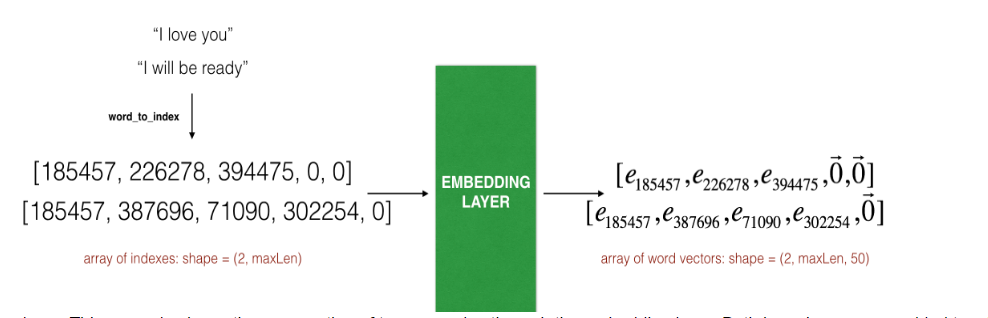

In [73]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 50

embeddings_index = {}
f = open('Data/glove.6B.50d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 86627 unique tokens.
Total 400000 word vectors.


In [74]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

# FORMULATING LABEL VECTOR

In [ ]:
categories = df.groupby('category').size().index.tolist()
category_int = {}

for i, k in enumerate(categories):
    category_int.update({k:i})
    

df['category_to_id'] = df['category'].apply(lambda x: category_int[x])

# TRAINING/VALIDATION SET SPLIT

In [77]:
X = np.array(X)
Y = np_utils.to_categorical(list(df.category_to_id))

In [78]:
from sklearn.model_selection import train_test_split
seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

# LSTM CLASSIFIER

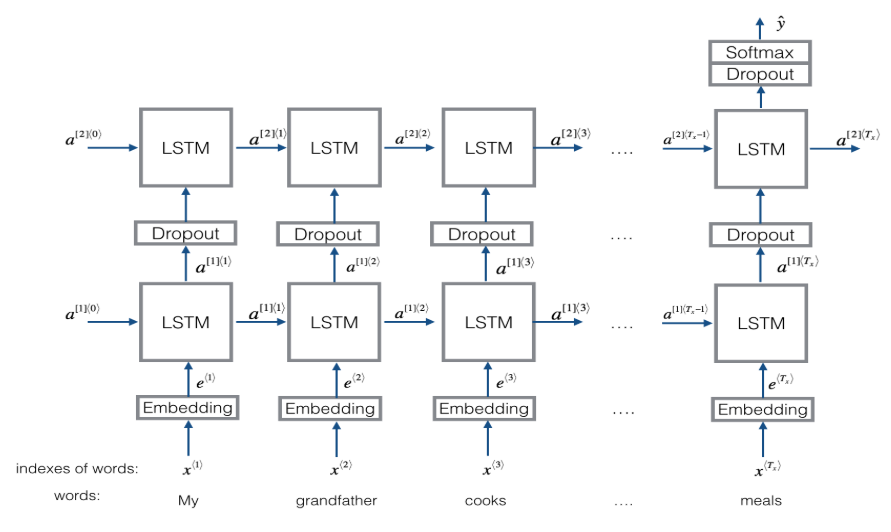

In [79]:
# GRADED FUNCTION: Emojify_V2

def News_LSTM(input_shape, word_to_vec_map, word_to_index):
   
    inp = Input(shape=(maxlen,), dtype='int32')
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings =  embedding_layer(inp)  
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128 ,return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    X = LSTM(128,return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(30)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=inp, outputs=X)
    
    return model

In [80]:
model = News_LSTM(50, word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 50)            4331400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 128)           91648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3870      
__________

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
model.fit(x_train, y_train, epochs = 5, batch_size = 32, shuffle=True)

Epoch 1/5
99254/99254 [==============================] - 340s 3ms/step - loss: 0.9088 - acc: 0.7346
Epoch 2/5
99254/99254 [==============================] - 339s 3ms/step - loss: 0.8983 - acc: 0.7391
Epoch 3/5
99254/99254 [==============================] - 328s 3ms/step - loss: 0.8919 - acc: 0.7394
Epoch 4/5
99254/99254 [==============================] - 335s 3ms/step - loss: 0.8797 - acc: 0.7435
Epoch 5/5
99254/99254 [==============================] - 337s 3ms/step - loss: 0.8707 - acc: 0.7466


In [85]:
model.save("News_LSTM.h5")

# VALIDATION SET ACCURACY = 59.6%

In [88]:
preds = model.evaluate(x_val, y_val)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

24814/24814 [==============================] - 28s 1ms/step
Loss = 1.6169292194833491
Test Accuracy = 0.5963165954847114
